# Mohammad Ali Mojtahed Soleimani

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from tqdm.notebook import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = 'bert-base-uncased'
num_epochs = 10
batch_size = 16
learning_rate = 2e-5
save_dir = './saved_models'
data_path = './IMDB.csv'

In [3]:
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [4]:
class IMDBDataset(Dataset):
    def __init__(self, reviews, labels, tokenizer, max_len):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = IMDBDataset(
        reviews=df.review.to_numpy(),
        labels=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(ds, batch_size=batch_size, num_workers=2)

In [5]:
df = pd.read_csv(data_path)


if df['sentiment'].dtype == 'object':
    label_map = {'positive': 1, 'negative': 0}
    df['sentiment'] = df['sentiment'].map(label_map)


In [6]:
train_df = df.sample(frac=0.8, random_state=42)  # 80% for training
test_df = df.drop(train_df.index)


tokenizer = BertTokenizer.from_pretrained(model_name)
MAX_LEN = 512

train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, batch_size)
test_data_loader = create_data_loader(test_df, tokenizer, MAX_LEN, batch_size)


model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)
model = model.to(device)


optimizer = AdamW(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [7]:
# --- Training Loop ---
train_losses = []
test_losses = []
train_f1_scores = []
test_f1_scores = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 10)

    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    train_preds = []
    train_targets = []

    for batch in tqdm(train_data_loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.logits, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        train_preds.extend(predicted.cpu().numpy())
        train_targets.extend(labels.cpu().numpy())

    avg_train_loss = train_loss / len(train_data_loader)
    train_losses.append(avg_train_loss)

    train_f1 = f1_score(train_targets, train_preds)
    train_f1_scores.append(train_f1)

    # --- Evaluation ---
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0
    test_preds = []
    test_targets = []

    with torch.no_grad():
        for batch in tqdm(test_data_loader, desc="Testing"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.logits, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

            test_preds.extend(predicted.cpu().numpy())
            test_targets.extend(labels.cpu().numpy())

    avg_test_loss = test_loss / len(test_data_loader)
    test_losses.append(avg_test_loss)

    test_f1 = f1_score(test_targets, test_preds)
    test_f1_scores.append(test_f1)

    print(f'Train Loss: {avg_train_loss:.4f}, Train F1: {train_f1:.4f}')
    print(f'Test Loss: {avg_test_loss:.4f}, Test F1: {test_f1:.4f}')

    torch.save(model.state_dict(), os.path.join(save_dir, f'model_epoch_{epoch+1}.pth'))


Epoch 1/10
----------


Training:   0%|          | 0/2500 [00:00<?, ?it/s]

Testing:   0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.2135, Train F1: 0.9153
Test Loss: 0.1643, Test F1: 0.9372
Epoch 2/10
----------


Training:   0%|          | 0/2500 [00:00<?, ?it/s]

Testing:   0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.1051, Train F1: 0.9625
Test Loss: 0.1981, Test F1: 0.9294
Epoch 3/10
----------


Training:   0%|          | 0/2500 [00:00<?, ?it/s]

Testing:   0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0585, Train F1: 0.9811
Test Loss: 0.2456, Test F1: 0.9368
Epoch 4/10
----------


Training:   0%|          | 0/2500 [00:00<?, ?it/s]

Testing:   0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0394, Train F1: 0.9874
Test Loss: 0.2268, Test F1: 0.9313
Epoch 5/10
----------


Training:   0%|          | 0/2500 [00:00<?, ?it/s]

Testing:   0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0287, Train F1: 0.9910
Test Loss: 0.3680, Test F1: 0.9248
Epoch 6/10
----------


Training:   0%|          | 0/2500 [00:00<?, ?it/s]

Testing:   0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0244, Train F1: 0.9922
Test Loss: 0.3063, Test F1: 0.9361
Epoch 7/10
----------


Training:   0%|          | 0/2500 [00:00<?, ?it/s]

Testing:   0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0197, Train F1: 0.9935
Test Loss: 0.2773, Test F1: 0.9375
Epoch 8/10
----------


Training:   0%|          | 0/2500 [00:00<?, ?it/s]

Testing:   0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0174, Train F1: 0.9944
Test Loss: 0.2705, Test F1: 0.9403
Epoch 9/10
----------


Training:   0%|          | 0/2500 [00:00<?, ?it/s]

Testing:   0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0152, Train F1: 0.9947
Test Loss: 0.2971, Test F1: 0.9389
Epoch 10/10
----------


Training:   0%|          | 0/2500 [00:00<?, ?it/s]

Testing:   0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0135, Train F1: 0.9954
Test Loss: 0.3697, Test F1: 0.9377


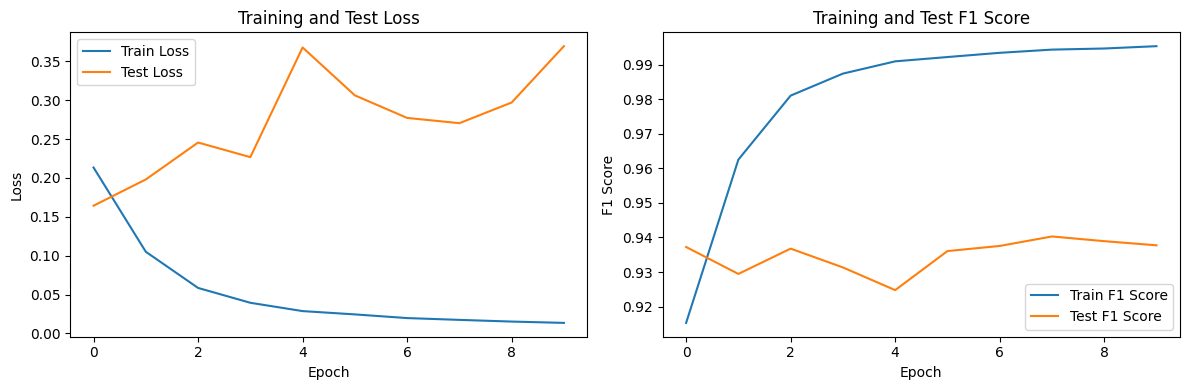

In [8]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_f1_scores, label='Train F1 Score')
plt.plot(test_f1_scores, label='Test F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Training and Test F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
model_path = os.path.join(save_dir, 'model_epoch_10.pth')
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

<ipython-input-9-de50ca5db7ba>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [10]:
pred_sentences = ['worst movie of my life, will never watch movies from this series',
                  'Wow, blew my mind, what a movie by Marvel, animation and story is amazing']

In [11]:
encoded_inputs = tokenizer(pred_sentences, max_length=128, padding=True, truncation=True, return_tensors='pt')
input_ids = encoded_inputs['input_ids'].to(device)
attention_mask = encoded_inputs['attention_mask'].to(device)

In [12]:
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)

In [13]:
probabilities = torch.nn.functional.softmax(outputs.logits, dim=1)
predicted_labels = torch.argmax(probabilities, dim=1)
predicted_labels = predicted_labels.cpu().numpy()

In [14]:
label_map = {0: 'Negative', 1: 'Positive'}
predicted_class_names = [label_map[label] for label in predicted_labels]

In [15]:
for i, sentence in enumerate(pred_sentences):
    print(f"{sentence} : {predicted_class_names[i]}")

worst movie of my life, will never watch movies from this series : Negative
Wow, blew my mind, what a movie by Marvel, animation and story is amazing : Positive
